In [21]:
import numpy as np
import os
import pandas as pd
import pickle
from zipfile import ZipFile

import mltoolz as mlt # not sure if this will work for others

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
ZIP_PATH = '../data/dataset.zip'

with ZipFile(ZIP_PATH, 'r') as z:
    with z.open(z.namelist()[0]) as f:
        df = pd.read_csv(f, parse_dates=['date'])

In [3]:
df

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
15337,2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
15338,2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN
15339,2020-12-30,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN


In [4]:
df.isna().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

- Fill NaNs in snow_depth with 0
- drop all other NaNs

** Could try to be clever and fill the NaNs in snow depth using the model we develop??

In [5]:
# handle NaN values
df['snow_depth'].fillna(0, inplace=True)
df.dropna(axis=0, inplace=True)

# Set date as index and sort
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [9]:
train = df[:10000]
test = df[10000:]

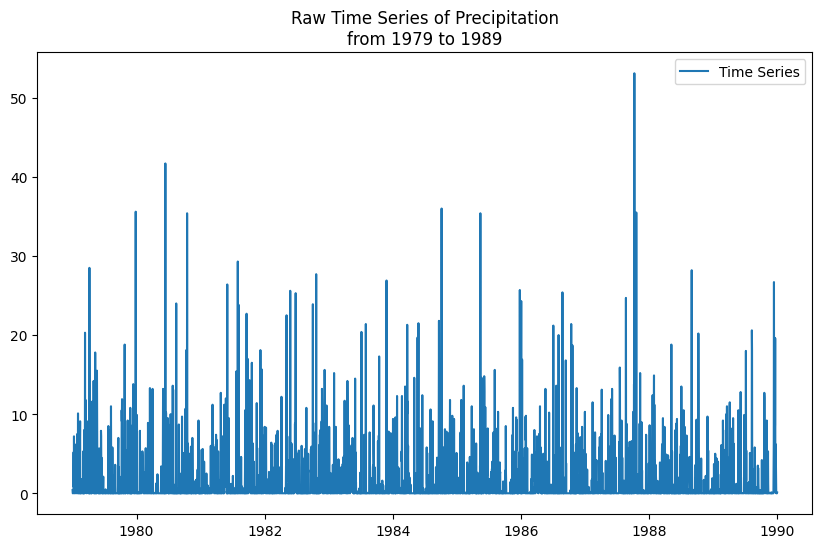

In [87]:
start_year = '1979'
end_year = '1989'
ts = train.loc[start_year:end_year]['precipitation']

plt.figure(figsize=(10,6))
plt.plot(ts, label='Time Series')
plt.title(f'Raw Time Series of Precipitation\nfrom {start_year} to {end_year}')
plt.legend()
plt.show()

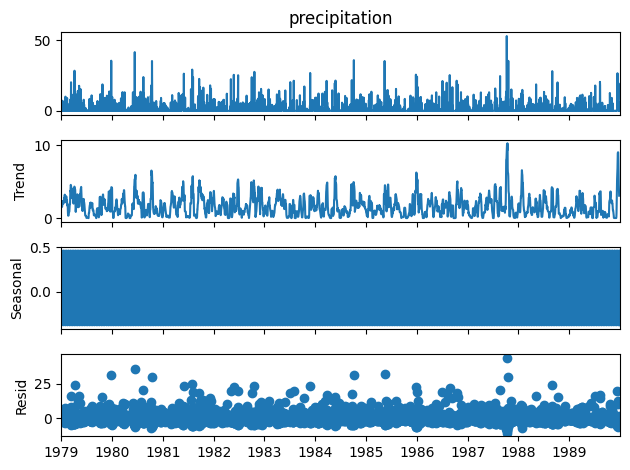

In [88]:
decomposed = seasonal_decompose(ts, model='additive', period=12)

decomposed.plot()
plt.tight_layout()
plt.show()

- Strong seasonality --> use SARIMA
- No overall trend suggests `Precipitation` Series is stationary

In [89]:
rolling_mean = ts.rolling(window=12).mean()
rolling_std = ts.rolling(window=12).std()

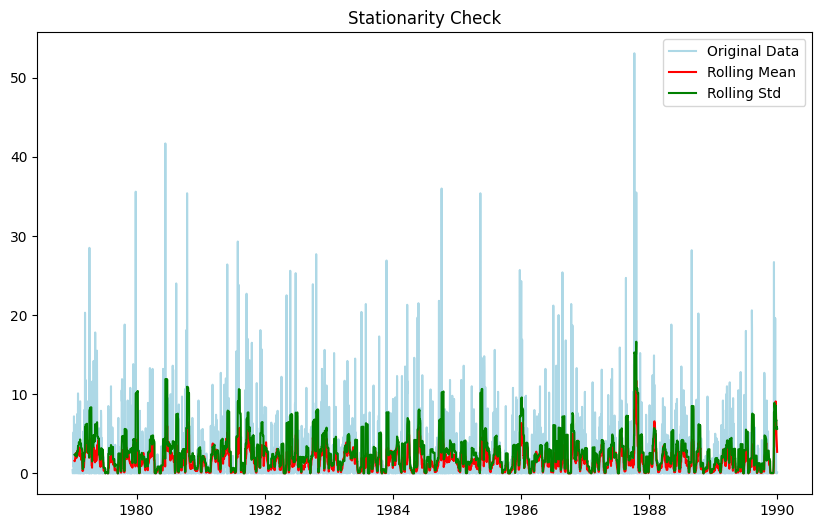

In [90]:
plt.figure(figsize=(10,6))

plt.plot(ts, label='Original Data', color='lightblue')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')

plt.legend()
plt.title('Stationarity Check')
plt.show()

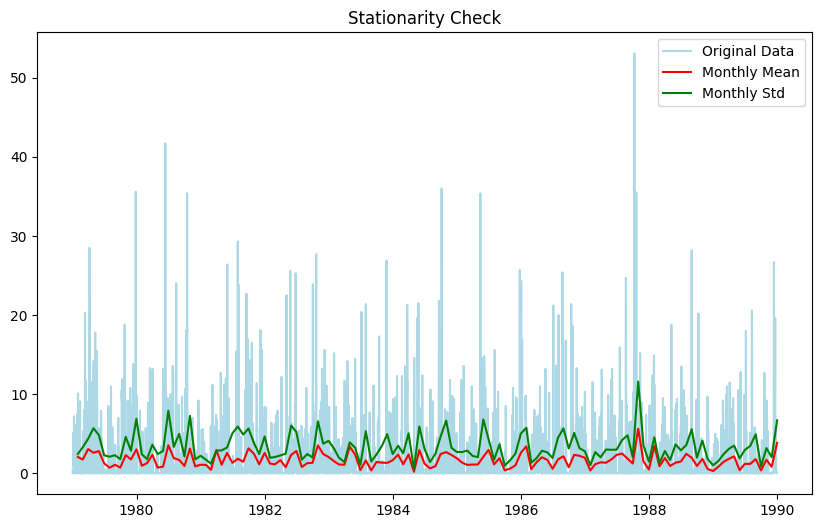

In [91]:
period = 'Monthly'
period_mean = ts.resample('M').mean()
period_std = ts.resample('M').std()

plt.figure(figsize=(10,6))

plt.plot(ts, label='Original Data', color='lightblue')
plt.plot(period_mean, label=f'{period} Mean', color='red')
plt.plot(period_std, label=f'{period} Std', color='green')

plt.legend()
plt.title('Stationarity Check')
plt.show()

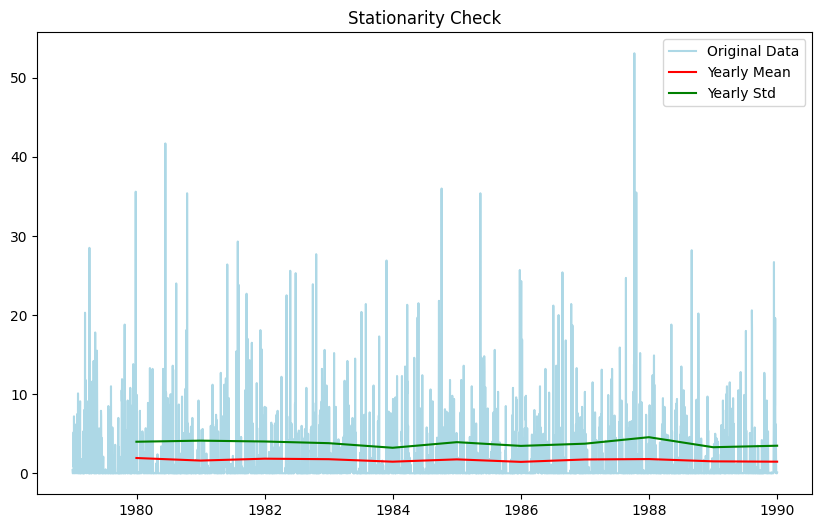

In [92]:
period = 'Yearly'
period_mean = ts.resample('Y').mean()
period_std = ts.resample('Y').std()

plt.figure(figsize=(10,6))

plt.plot(ts, label='Original Data', color='lightblue')
plt.plot(period_mean, label=f'{period} Mean', color='red')
plt.plot(period_std, label=f'{period} Std', color='green')

plt.legend()
plt.title('Stationarity Check')
plt.show()

In [93]:
ADF_res = adfuller(train.loc[start_year:end_year]['precipitation'])

print(f'ADF Statistic: {ADF_res[0]}')
print(f'p-value: {ADF_res[1]}')
print(f'Critical Values: {ADF_res[4]}')
if ADF_res[1] < 0.05:
    print('Reject the null hypothesis. Series is stationary')
else:
    print('Cannot reject null hypothesis. Series is NOT stationary')

ADF Statistic: -24.606379863353744
p-value: 0.0
Critical Values: {'1%': -3.431986694239327, '5%': -2.8622632019846224, '10%': -2.567154968134392}
Reject the null hypothesis. Series is stationary


---
Investigating autocorrelation

In [74]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1000x600 with 0 Axes>

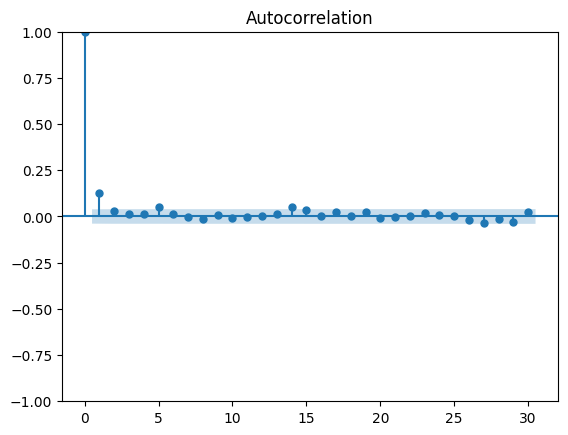

In [80]:
plt.figure(figsize=(10,6))
plot_acf(ts, lags=30)
plt.show()

<Figure size 1000x600 with 0 Axes>

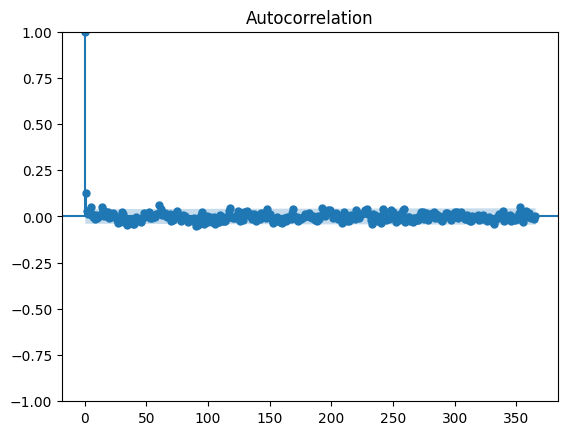

In [86]:
plt.figure(figsize=(10,6))
plot_acf(ts, lags=365)
plt.show()

Autocorelation lags = 30:  
- As AC becomes insignificant beyond lag 1 suggests moving average order of q=1
- Not showing clear seasonality with lags=30

Autocorrelation lags = 365:  
- still not showing strong seasonal patterns so dont need to use SARIMA

<Figure size 1000x600 with 0 Axes>

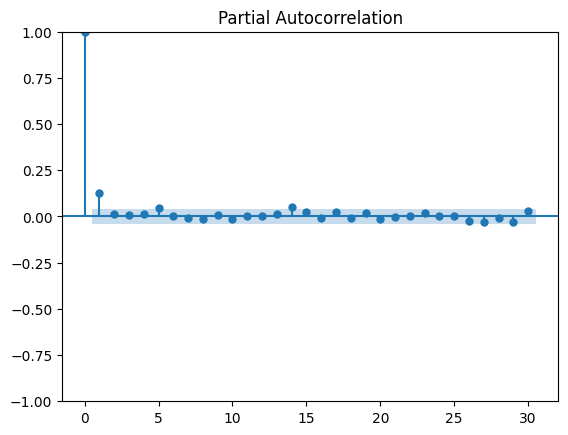

In [77]:
plt.figure(figsize=(10,6))
plot_pacf(ts, lags=30, method='ywm')
plt.show()

- PACF plot indicates only lag 1 is significant, so autoregressive order is p=1
- As ADF test indicated that series is stantionary, no differencing required, so d=0

<Figure size 1000x600 with 0 Axes>

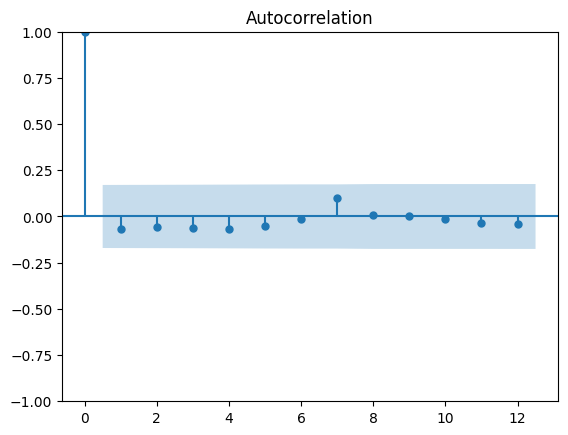

In [ ]:
period = 'Monthly'
period_mean = ts.resample('M').mean()

plt.figure(figsize=(10,6))
plot_acf(period_mean, lags=12)
plt.show()

<Figure size 1000x600 with 0 Axes>

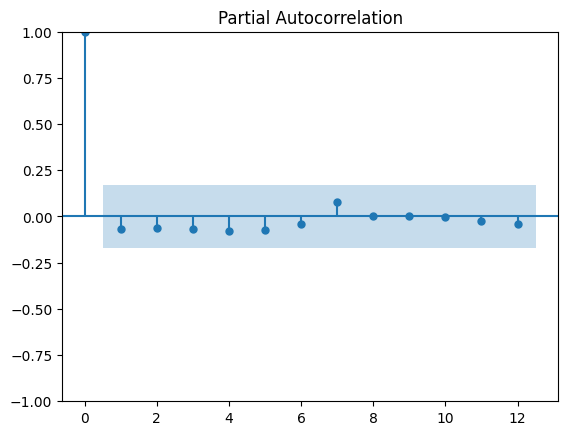

In [ ]:
plt.figure(figsize=(10,6))
plot_pacf(period_mean, lags=12, method='ywm')
plt.show()

- If there is no seasonality being detected in rainfall data does this just suggest that there are no seasonal changes in rainfall patterns.
- E.g the weahter is always shit

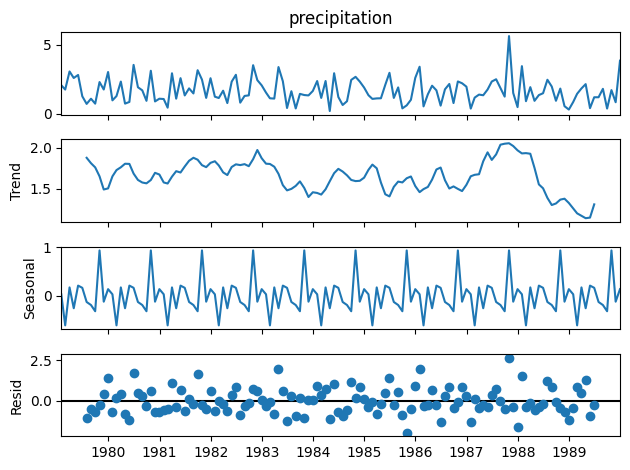

In [100]:
decomposition = seasonal_decompose(period_mean, model='additive', period=12)
decomposition.plot()
plt.show()

decomposition of monthly mean precipitation shows definite seasonality